<a href="https://colab.research.google.com/github/ArTeDS/Sentiment-Analysis-on-Streaming-Covid_19-Tweets/blob/main/tweets_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Preprocess Data

In [ ]:
# laod the parquet files into a dataframe
#! pip install pyarrow
import pandas as pd
parguet_file = r'C:\Data Science\MSc Data Science\Big Data Management and Processing\Project\Twitter_Streaming_Sentiment_Analysis\parquet'
df=pd.read_parquet(parguet_file, engine='auto')
df

,word,polarity,subjectivity
0,,0.0,0.0
1,One of the weird things over the last few ye...,-0.09,0.30333333333333334
2,Petition Do not make COVID vaccination a requi...,0.03333333333333333,0.06666666666666667
3,If you go to the South they have been over C...,0.35,0.55
4,If you go to the South they have been over C...,0.35,0.55
...,...,...,...
43161,Almost 2000 people a week are dying with cov...,0.0,0.0
43162,Spain has some of the most beautiful horse's â...,0.675,0.75
43163,- Claim pandemic is over,0.0,0.0
43164,âš½ï¸� In game fatigue,-0.4,0.4


In [ ]:
# drop duplicates - retweets
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(len(df))

20806


In [ ]:
df['polarity'] = df['polarity'].astype(float)
df['subjectivity'] = df['subjectivity'].astype(float)

In [ ]:
# setting labels for the polarity
df['polarity_measure'] = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in df.polarity]

# setting labels for the subjectivity
df['subjectivity_measure'] = ['highly_objective' if score < 0.1428 
                                    else 'objective' if score < 0.2856
                                        else 'partially_objective' if score <0.4284
                                            else 'neutral' if score < 0.5712
                                                else 'partially_subjective' if score < 0.714
                                                    else 'subjective' if score < 0.8568
                                                        else 'highly_subjective'                                                                               
                                                              for score in df.subjectivity]

### Text Preprocessing

In [ ]:
# Function for text preprocessing

# !pip install spacy
# !python -m spacy download en_core_web_sm
# nltk.download('words')
# nltk.download('stopwords')

# Function for text preprocessing
import string
import re
import nltk
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import spacy

# set puncuation and stopwords into one list
punctuation = list(string.punctuation)
# punctuation.remove('-')

# english stopwords
stopwords = nltk.corpus.stopwords.words('english')

# load spaCY english language
nlp = spacy.load('en_core_web_sm')

# Snowball Stemmer
stemmer = SnowballStemmer('english')


def preprocess(df, s_column, t_column, lemmatize=False, stem=False):
    
    # df: DataFrame
    # s_column: source column. The one that is to be processed
    # t_column: target column. The one created with the preprocessed text
    
    # lowercase
    
    df[t_column] = df[s_column].str.lower()
       
     # remove whitespaces
    df[t_column] = df[t_column].apply(lambda x : ( re.sub(' +', ' ', x)))
    
    # remove numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    df[t_column] = df[t_column].apply(lambda x : (re.sub("\S*\d\S*"," ", x)))
    
    # removes emails and mentions (words with @)
    df[t_column] = df[t_column].apply(lambda x : (re.sub("\S*@\S*\s?"," ", x)))
    
    # remove url 
    df[t_column] = df[t_column].apply(lambda x : ( re.sub(r'http\S+|www.\S+', r'', x)))
    
    if lemmatize == True:
        df[t_column] = df[t_column].apply(lambda x: ' '.join([w.lemma_ for w in nlp(x)]))
    
    # remove words with less than 3 letters 
    df[t_column] = df[t_column].apply(lambda x : (re.sub(r'\b\w{1,2}\b', '', x)))
    
    # remove noise (e.g. numbers, symbols)
    #df[t_column] = df[t_column].apply(lambda x : (re.sub('[^a-z\s]', ' ',x)))
    
    # remove punctuation
    df[t_column] = df[t_column].apply(lambda x: ''.join([word for word in x if word not in (punctuation)]))
    
    # remove words with 14 or more letters
    df[t_column] = df[t_column].apply(lambda x : (re.sub(r'\b\w{14,1000}\b', '', x)))
    
        
    # stem every word
    if stem == True:
        # remove stopwords
        df[t_column] = df[t_column].apply(lambda x: ([word for word in x.split() if word not in (stopwords)]))
        
        # stemmer
        df[t_column] = df[t_column].apply(lambda x: ', '.join([stemmer.stem(y) for y in x])) 
    
    else:
        # remove stopwords
        df[t_column] = df[t_column].apply(lambda x: ', '.join([word for word in x.split() if word not in (stopwords)]))
        
    return df
    

In [ ]:
preprocess(df, 'word', 'tokens', lemmatize=True)

,word,polarity,subjectivity,polarity_measure,subjectivity_measure,tokens
0,,0.000000,0.000000,neutral,highly_objective,
1,One of the weird things over the last few ye...,-0.090000,0.303333,negative,partially_objective,"one, weird, thing, last, year, people, consist..."
2,Petition Do not make COVID vaccination a requi...,0.033333,0.066667,positive,highly_objective,"petition, make, covid, vaccination, requiremen..."
3,If you go to the South they have been over C...,0.350000,0.550000,positive,neutral,"south, covid, like, full, year"
4,The bullshitandspin machine is off the scale...,0.000000,0.000000,neutral,highly_objective,"machine, scale"
...,...,...,...,...,...,...
20801,Boris said 'Let the bodies pile high'! - and t...,0.250000,0.540000,positive,neutral,"boris, say, let, body, pile, high"
20802,Almost 2000 people a week are dying with cov...,0.000000,0.000000,neutral,highly_objective,"almost, people, week, die, covid"
20803,Spain has some of the most beautiful horse's â...,0.675000,0.750000,positive,subjective,"spain, beautiful, horse, �, ¤¸, �"
20804,âš½ï¸� In game fatigue,-0.400000,0.400000,negative,partially_objective,"âš½ï¸, �, game, fatigue"


## Predictions for tweets containing real and fake news regarding Covid-19

In [ ]:
# Load the pretrained model for identifying which of the tweets contain real news and fake news about covid19
import joblib
MNB_Covid_Tweets_Real_Fake = joblib.load('MNB_Covid_Tweets_Real_Fake.pkl')

In [ ]:
# Use the loaded model to make predictions
y_pred = MNB_Covid_Tweets_Real_Fake.predict(df.tokens)
print(len(y_pred))

20806


In [ ]:
# add a column witht the predictions on the dataframe
df['real_fake'] = y_pred

# create column with string labels for real and fake news
label = {0: 'fake',
         1: 'real'}

df['real_fake_label'] = df['real_fake'].map(label)

# drop boolean labels
df.drop(columns='real_fake', inplace=True)
df.head(5)

,word,polarity,subjectivity,polarity_measure,subjectivity_measure,tokens,real_fake_label
0,,0.000000,0.000000,neutral,highly_objective,,fake
1,One of the weird things over the last few ye...,-0.090000,0.303333,negative,partially_objective,"one, weird, thing, last, year, people, consist...",fake
2,Petition Do not make COVID vaccination a requi...,0.033333,0.066667,positive,highly_objective,"petition, make, covid, vaccination, requiremen...",real
3,If you go to the South they have been over C...,0.350000,0.550000,positive,neutral,"south, covid, like, full, year",real
4,The bullshitandspin machine is off the scale...,0.000000,0.000000,neutral,highly_objective,"machine, scale",real


## Data Analysis

### Real and Fake News

In [ ]:
df.real_fake_label.value_counts()

fake    13839
real     6967
Name: real_fake_label, dtype: int64

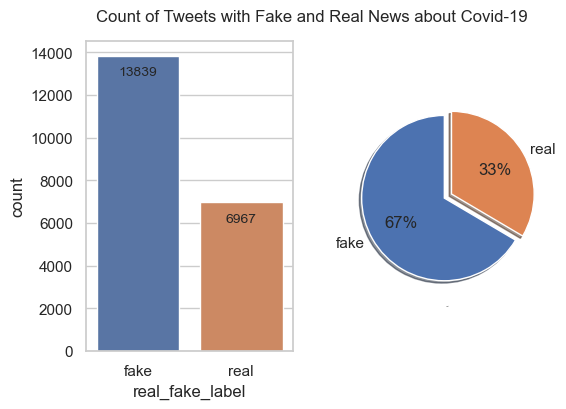

In [ ]:
# plot labels count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(6, 4), 
                         dpi=100)
fig.subplots_adjust(top=0.9, wspace=0.25)

g = sns.countplot(x=df['real_fake_label'], ax=axes[0])  
             #order=['real', 'fake'])

labels=['fake', 'real']

# add annotations to bar chart
for bar in g.patches:
    g.annotate(format(bar.get_height(), '.0f'),  # the number before f represents the decimals 
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=10, xytext=(0, -12), 
                   textcoords='offset points')

axes[1].pie(df['real_fake_label'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode = (0.05, 0.05))

plt.tick_params(direction='out', axis='x', labelsize=20, length=6, width=2, grid_alpha=0.5)
plt.xlabel('count',size=0) 
plt.ylabel('', size=0) 

sns.color_palette("pastel")
 
fig.suptitle('Count of Tweets with Fake and Real News about Covid-19', fontsize=12)
plt.show()

### Polarity and Subjectivity

The polarity score is a float within the range **[-1.0, 1.0]**.  
The subjectivity is a float within the range **[0.0, 1.0]** where 0.0 is very objective and 1.0 is very subjective.  
Let’s use this now to get the sentiment polarity and labels for each news article and aggregate the summary statistics per news category.  

<br>

Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. 

In [ ]:
df.groupby('subjectivity_measure').size()

subjectivity_measure
highly_objective        8922
highly_subjective       1474
neutral                 3411
objective               1230
partially_objective     2560
partially_subjective    2009
subjective              1200
dtype: int64

In [ ]:
df.subjectivity_measure.value_counts()

highly_objective        8922
neutral                 3411
partially_objective     2560
partially_subjective    2009
highly_subjective       1474
objective               1230
subjective              1200
Name: subjectivity_measure, dtype: int64

Text(0, 0.5, '')

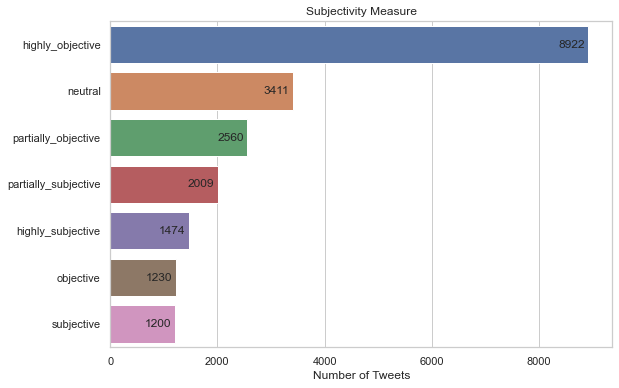

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (9,6))
# Ploting the Subjectivity Measure
g = sns.barplot(x=df.groupby('subjectivity_measure').size().sort_values(ascending=False).values, 
                    y=df.groupby('subjectivity_measure').size().sort_values(ascending=False).index,
                    )
# annotations
for bar in g.patches:
    g.annotate(format(bar.get_width(), '.0f'), xy=(bar.get_width(), bar.get_y()+bar.get_height()/2),
            xytext=(-30, 0), size=12, textcoords='offset points', ha="left", va="center")

plt.title('Subjectivity Measure')
plt.xlabel('Number of Tweets')
plt.ylabel('')

Text(0, 0.5, '')

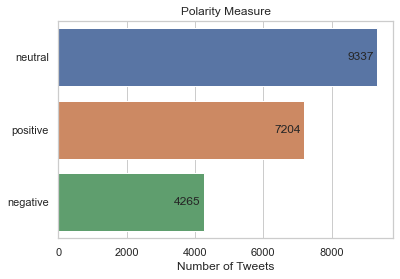

In [ ]:
# ploting the Polarity measure
fig = plt.figure(figsize = (6,4))
g = sns.barplot(x=df.groupby('polarity_measure').size().sort_values(ascending=False).values, 
                    y=df.groupby('polarity_measure').size().sort_values(ascending=False).index
                    )
# annotations
for bar in g.patches:
    g.annotate(format(bar.get_width(), '.0f'), xy=(bar.get_width(), bar.get_y()+bar.get_height()/2),
            xytext=(-30, 0), size=12, textcoords='offset points', ha="left", va="center")
    
plt.title('Polarity Measure')
plt.xlabel('Number of Tweets')
plt.ylabel('')